# BME 511 Midterm Project Solutions (Rough)

Checking with single-channel data on Subject #6 to see if the idea basically works.

In [1]:
# Setting it so figs will be a bit bigger
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi']  = 120

Importing the usual libraries and copying the functions provided for dealing with events.

In [2]:
import pylab as pl
import numpy as np
import datetime

def unpackStamp(x):
    y = np.int32(x[0])
    mo = np.int32(x[1])
    d = np.int32(x[2])
    h = np.int32(x[3])
    mi = np.int32(x[4])
    s = x[5]
    s_new = np.int32(np.floor(s))
    micros = np.int32((s - s_new) * 1e6)
    unpacked = datetime.datetime(y, mo, d, h, mi, s_new, micros)
    return unpacked

def events2samps(events, fs):
    firsteve_time = 0.4
    Nevents = events.shape[0]
    evesamps = np.zeros(Nevents)
    for k in range(Nevents):
        td =  unpackStamp(events[k, :]) - unpackStamp(events[0, :])
        evesamps[k] = np.int32(np.round(td.total_seconds()*fs + firsteve_time*fs + 1))
    
    return evesamps

## Epoching

It is useful to separate the epoching step into a function so as to keep the code clean and easier to debug. This function also does baseline correction, and rejects "bad" epochs, i.e., the ones exceeding some threshold (40 microvolts here) in either direction.

In [3]:
# Function to do epoching (and epoch rejection) on a single channel
def epoching(x, fs, evesamps, tmin, tmax, bmin, bmax, reject):
    imin = np.int32(np.round(tmin * fs))
    imax = np.int32(np.round(tmax * fs))
    iminb = np.int32(np.round(bmin * fs))
    imaxb = np.int32(np.round(bmax * fs))
    nepochs = evesamps.shape[0]
    ntimes = imax - imin
    epochs = np.zeros((nepochs, ntimes))
    good_epochs = []
    for k, eve in enumerate(evesamps):
        epoch = x[(imin + np.int32(eve)):(imax + np.int32(eve))].copy()
        bline = epoch[iminb:imaxb].mean()
        epoch -= bline
        epochs[k, :] = epoch.copy()
        if abs(epoch).max() < reject:
            good_epochs += [k, ]
    
    return epochs[good_epochs, ]

In [4]:
import os
import fnmatch
from scipy import io, signal

fs = 2048  # Given
subj = 'subject6'
channel = 30  # Fz
nsessions = 4

targetlist = []
nontargetlist = []
for k in range(nsessions):
    fpath = subj + '/session' + str(k + 1) + '/'
    fnames = fnmatch.filter(os.listdir(fpath), '*.mat')
    for kf, fname in enumerate(fnames):
        allvars = io.loadmat(fpath + fname, squeeze_me=True)
        evesamps = events2samps(allvars['events'], fs)

        # Filter design
        nfilt = 8500
        f_low = 12
        f_high = 1
        h = signal.firwin(nfilt, [f_high, f_low], pass_zero='bandpass', fs=fs)

        # Re-reference and filter data
        mastoidchans = [32, 33]
        ref = allvars['data'][mastoidchans, :].mean(axis=0)
        xraw = allvars['data'][channel, :] - ref
        x = signal.filtfilt(h, 1, xraw)

        # Set parameters for epopching
        tmin, tmax = 0, 1.0  # Seconds
        bmin, bmax = 0, 0.1  # Seconds
        reject = 40  # Microvolts
        
        # Do all targets firsts
        targetsamps = evesamps[allvars['stimuli'] == allvars['target']]
        targetlist += [epoching(x, fs, targetsamps, tmin, tmax, bmin, bmax, reject), ]
        
        # Do all nontargets next
        nontargetsamps = evesamps[allvars['stimuli'] != allvars['target']]
        nontargetlist += [epoching(x, fs, nontargetsamps, tmin, tmax, bmin, bmax, reject), ]

targets = np.concatenate(targetlist, axis=0)
nontargets = np.concatenate(nontargetlist, axis=0)

Text(0.5, 1.0, 'Subject 6, Channel Fz')

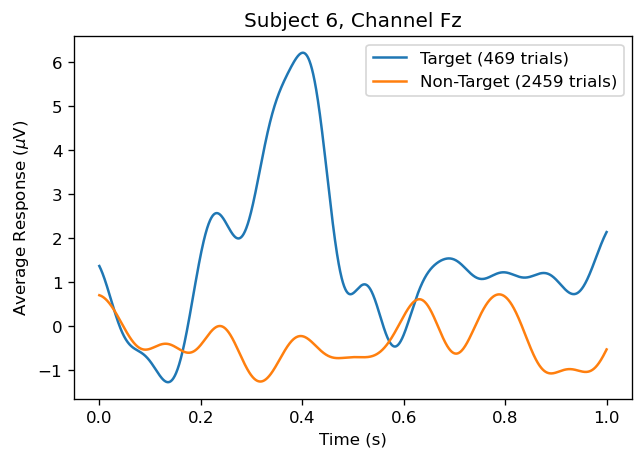

In [5]:
targetAve = targets.mean(axis=0)
nontargetAve = nontargets.mean(axis=0)
t = np.arange(tmin, tmax, 1.0/fs)

pl.plot(t, targetAve)
pl.plot(t, nontargetAve)
leg1 = 'Target (' + str(targets.shape[0]) + ' trials)'
leg2 = 'Non-Target (' + str(nontargets.shape[0]) + ' trials)'
pl.legend((leg1, leg2), loc='best')
pl.xlabel('Time (s)')
pl.ylabel('Average Response ($\mu$V)')
pl.title('Subject 6, Channel Fz')

## Generate null examples

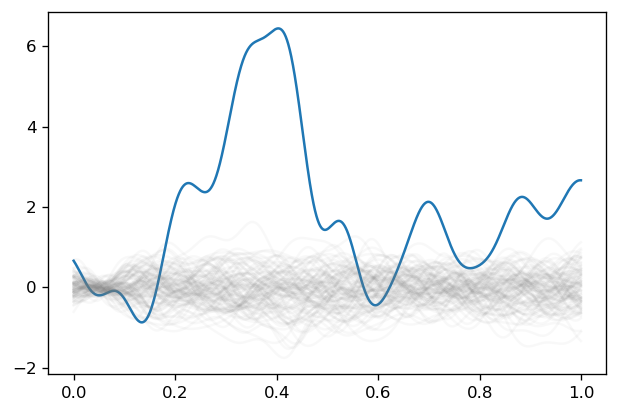

In [6]:
# Plot actual target vs. non-target difference
pl.plot(t, targetAve - nontargetAve)

basket = np.concatenate((targets, nontargets), axis=0)
nepochs = basket.shape[0]
ntargets = targets.shape[0]
nnontargets = nontargets.shape[0]

nbreaks = 100
maxvals = np.zeros(nbreaks)
flip = np.concatenate([np.ones(ntargets) / ntargets, np.ones(nnontargets)* -1 / nnontargets])
for k in range(nbreaks):
    flip = flip[np.random.permutation(nepochs)]
    diff_perm = (basket * flip[:, None]).sum(axis=0)
    maxvals[k] = abs(diff_perm).max()
    pl.plot(t, diff_perm, color=[0.5, 0.5, 0.5], alpha=0.05)

## Feature extraction

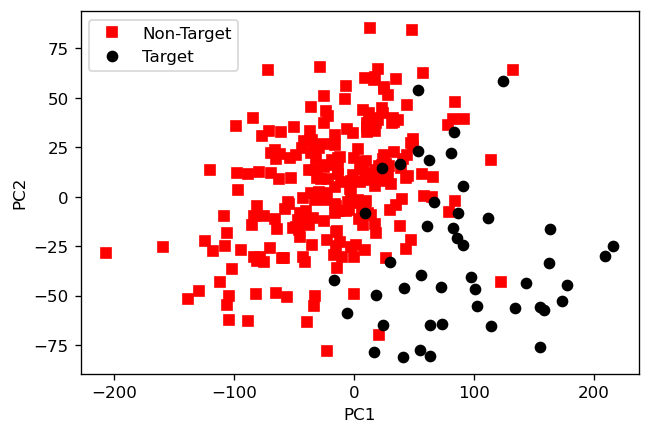

In [7]:
from skimage.measure import block_reduce
from sklearn.decomposition import PCA


basket = np.concatenate((targets, nontargets), axis=0)
K = 10
basket_pooled = block_reduce(basket, block_size=(K, 1), func=np.mean)
chs = [12, 15, 30, 31]  # For later.. for now, just test with one channel
wmin, wmax = 0.2, 0.6  # From previous plot
iminw, imaxw = np.int32(np.round(wmin * fs)), np.int32(np.round(wmax * fs))
X = basket_pooled[:, iminw:imaxw]


# Do PCA to get 2 dimensions
pc = PCA(n_components=2)
pc.fit(X)
X_pc = pc.transform(X)

ntargetsK = np.int32(ntargets/K)
pl.plot(X_pc[ntargetsK:, 0], X_pc[ntargetsK:, 1], 'sr')
pl.plot(X_pc[:ntargetsK, 0], X_pc[:ntargetsK, 1], 'ok')
pl.xlabel('PC1')
pl.ylabel('PC2')
pl.legend(('Non-Target', 'Target'))